#### 12/01/2021

We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Conclusion](#Final_Conclusion)


<a id='intro'></a>
## Introduction

For this project, We will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.




## Data description

This data is given by Udacity Advanced Data Analysis Nanodegree Program, It consists of two CSV files countries.csv and ab_data.csv.
The two CSV files are [here](https://video.udacity-data.com/topher/2017/December/5a32c9a0_analyzeabtestresults-2/analyzeabtestresults-2.zip).

Below is the description of ab_data.csv, there are a total of 5 columns:

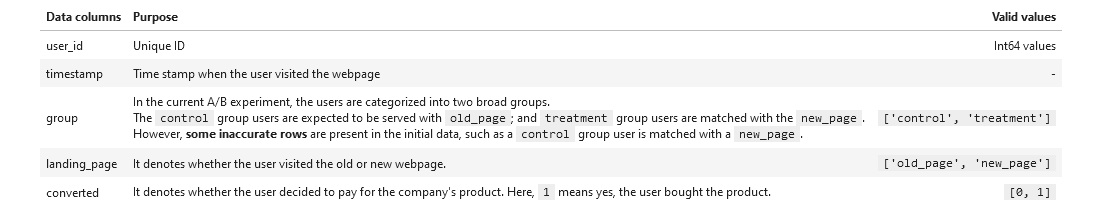 

## Set up the environment

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

### ToDo 1.1

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:


In [2]:
df = pd.read_csv('/kaggle/input/analyze-ab-test-results-notebook/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [5]:
sum(df['converted'])/df.shape[0]

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.query('group == "treatment" & landing_page != "new_page"').shape[0]

1965

**f.** Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


There is no missing values.

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

Store new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2

df2 = df.query('(group == "treatment" & landing_page == "new_page")|(group == "control" & landing_page == "old_page")')
df2.shape[0]

290585

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.2

**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [12]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop([2893])
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'].duplicated()]


,user_id,timestamp,group,landing_page,converted


### ToDo 1.3

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [14]:
#df.reset_index()

p_population = df2.query('converted == 1').shape[0]/df2.shape[0]
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_control_converted = df2.query('group == "control" & converted == 1').shape[0]/df2.query('group == "control"').shape[0]
p_control_converted

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treatment_converted = df2.query('group == "treatment" & converted == 1').shape[0]/df2.query('group == "treatment"').shape[0]
p_treatment_converted


0.11880806551510564

Calculate the actual difference between the conversion rates for the two groups.

In [17]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment_converted - p_control_converted
obs_diff

-0.0015782389853555567

>The actual difference between the conversion rates for the two groups is 0.0016 in favor of the control group, So the new treatment group users do not lead to more conversions.

**d.** What is the probability that an individual received the new page?

In [18]:
p_population_newpage = df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]
p_population_newpage

0.5000619442226688

<a id='ab_test'></a>
## Part II - A/B Test

### ToDo 2.1
For now, consider we need to make the decision just based on all the data provided.  

If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be our null and alternative hypotheses (**$H_0$** and **$H_1$**)?  


>$$H_0:  p_{new} - p_{old} \le 0 $$

$$H_1:  p_{new} - p_{old}  > 0 $$

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, We will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [19]:
p_new = p_population
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [20]:
p_old = p_population
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [21]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [23]:
# Simulate a Sample for the treatment Group

new_page_converted = np.random.choice([0,1],p=[1-p_new,p_new], size = n_new)
converted_probability_new = sum(new_page_converted == 1) / n_new
converted_probability_new

0.12007432385933521

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [24]:
# Simulate a Sample for the control Group

old_page_converted = np.random.choice([0,1],p=[1-p_old,p_old], size = n_old)
converted_probability_old = sum(old_page_converted == 1) / n_old
converted_probability_old

0.11714415518262043

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for our simulated samples from the parts (e) and (f) above. 

In [25]:
converted_probability_diff = converted_probability_new - converted_probability_old
converted_probability_diff

0.0029301686767147783


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process we used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [26]:
# Sampling distribution 
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.

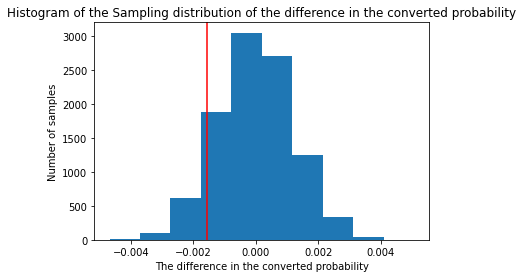

In [27]:
null_val = np.random.normal(0, np.array(p_diffs).std(), np.array(p_diffs).size)
plt.hist(null_val)
plt.axvline(x=obs_diff,color='red')
plt.xlabel('The difference in the converted probability')
plt.ylabel('Number of samples')
plt.title('Histogram of the Sampling distribution of the difference in the converted probability');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data? In other words, what is the p-value?

In [28]:
p_val = (null_val > obs_diff).mean()
p_val

0.9064

> Since the p-value is much more than the type I error rate, We can not reject the null hypothesis. Therefore, There is no significant difference between the old and the new pages.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.

In [29]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = sum(df2.query('landing_page == "old_page"')['converted'])

# number of conversions with the new_page
convert_new = sum(df2.query('landing_page == "new_page"')['converted'])

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"').shape[0]

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"').shape[0]

count = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])

count, nobs

(array([17264, 17489]), array([145310, 145274]))

- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page

**m.** Now use `sm.stats.proportions_ztest()` to compute our test statistic and p-value.

where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that we have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for our two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. we can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.
- $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. 

 

In [30]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


> The $Z_{score}$ is less than $Z_{0.05}$, So we fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** The goal is to use **statsmodels** library to fit the Logistic regression model to see if there is a significant difference in conversion based on the page-type a customer receives. However, we first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [31]:
df2['intercept'] = 1
df2[['control_page','ab_page']] = pd.get_dummies(df2['group'])
df2.drop(['control_page'], axis=1, inplace = True)

**b.** Use **statsmodels** to instantiate our regression model on the two columns we created in part (a) above, then fit the model to predict whether or not an individual converts. 


In [32]:
import statsmodels.api as sm;

lrm = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
res= lrm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**c.** Provide the summary of our model below, and use it as necessary to answer the following questions.

In [33]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-01-17 04:22 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**d.** What is the p-value associated with **ab_page**? Why does it differ from the value we found in **Part II**?<br><br>  

>* p-value = 0.1899, failing to reject the null hypothesis.
* The p-value differs from the value found in Part II Because the p-value here tests if the parameter equals zero in the null hypothesis.
* Null and alternative hypothesis from Logistic regression (two-tailed test):
$$H_0:  p_{new} - p_{old} = 0 $$
$$H_1:  p_{new} - p_{old} \neq 0 $$
* While null and alternative hypothesis from part II (one-tailed test):
$$H_0:  p_{new} - p_{old} \le 0 $$
$$H_1:  p_{new} - p_{old}  > 0 $$
Where,
- $H_0$ is the null hypothesis.
- $H_1$ is the alternative hypothesis.
- $p_{new}$ and $p_{old}$ are the "converted" success rates for the two groups in the population. 


**e. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. We will need to read in the **countries.csv** dataset and merge together our `df2` datasets on the appropriate rows. We call the resulting dataframe `df_merged`.

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns.  

In [34]:
# Read the countries.csv
countries = pd.read_csv('/kaggle/input/countries/countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [35]:
# Join with the df2 dataframe

df_merged = df2.join(countries['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,UK
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,UK
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,UK
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,UK


In [36]:
# Create the necessary dummy variables
df_merged[['CA', 'UK' , 'US']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,UK,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,UK,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,UK,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,UK,0,1,0


In [37]:
# Fitting model, and summarize the results

lrm_2 = sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page','UK', 'CA']])
res_2= lrm_2.fit()
res_2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212783.0474
Date:               2022-01-17 04:22 BIC:              212825.3660
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.38835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9891    0.0089  -224.0205  0.0000  -2.0065  -1.9717
ab_page      -0.0150    0.0114    -1.3084  0.1907  -0.0374   0.0074
UK            0.0065    0.0134     0.4850  0.6277  -0.0197   0.0327
CA           -0.0258    0.0269    -0.9589  0.3376  -0.0785   0.0269
==================================================================

"""

>* The p-value of 'ab_page' with the country 'US' is more than the Type I error rate (0.05), So they have no statistically significant effects on conversion.
* Also the confidence intervals of each of the countries ('UK' and 'CA') and 'ab_page' are overlapping. Therefore, There are no statistically significant effects on conversion.
* We failed to reject the null hypothesis as a result of the above conclusion.

**h. Fit our model and obtain the results**<br> 
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.

In [38]:
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_CA'] = df_merged['ab_page'] * df_merged['CA']

In [39]:
# Fitting model, and summarize the results

lrm_2 = sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page','UK','CA','ab_UK', 'ab_CA']])
res_2= lrm_2.fit()
res_2.summary2()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212784.6547
Date:               2022-01-17 04:22 BIC:              212848.1326
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.36746    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9859    0.0096  -206.7920  0.0000  -2.0047  -1.9670
ab_page      -0.0215    0.0136    -1.5817  0.1137  -0.0482   0.0052
UK            0.0013    0.0188     0.0669  0.9467  -0.0356   0.0381
CA           -0.0675    0.0385    -1.7528  0.0796  -0.1430   0.0080
ab_UK         0.0105    0.0267     0.3937  0.6938  -0.0419   0.0629
ab_CA         0.0825    0.0538     1.5339  0.1251  -0.0229   0.1880
==================================================================

"""

>* The p-value of interaction between the page and the countries are more than the Type I error rate (0.05), p-values are 0.6938 and 0.1251, So they have no statistically significant effects on conversion.
* We failed to reject the null hypothesis as a result of the above conclusion.

<a id='Final_Conclusion'></a>
 ### Final conclusion

* From the analysis we made, we fail to reject the null hypothesis for all the cases mentioned above, Which was that there is no significant difference between the old page and the new one. 

* Finally we reach a conclusion:
We should keep the old page for the foreseeable future until we could gather new data that may give us more evidence that the new page is better.